In [1]:
!pip install transformers==4.44.2 datasets==2.21.0 scikit-learn==1.5.2 matplotlib==3.9.2 seaborn==0.13.2

In [2]:
import transformers, datasets, sklearn, matplotlib, seaborn
print("✅ All libraries imported successfully!")

✅ All libraries imported successfully!


In [3]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"mohitredhu8797","key":"8cdfc294a9052e6f4dd6a8ee2812ce2a"}'}

In [4]:
from pathlib import Path
import os
KAGGLE_JSON = "/content/kaggle.json"
if not Path(KAGGLE_JSON).exists():
    print("Please upload your kaggle.json to /content")
else:
    os.environ["KAGGLE_CONFIG_DIR"] = "/content"
    print("kaggle.json found.")

kaggle.json found.


In [5]:
# Cell 3 — Download dataset from Kaggle (adjust if you use another dataset)
!kaggle datasets download -d shivajeetrai/hinglish-data-for-sentiment-analysis -p /content --unzip
!ls -lah /content

Dataset URL: https://www.kaggle.com/datasets/shivajeetrai/hinglish-data-for-sentiment-analysis
License(s): unknown
  0% 0.00/132k [00:00<?, ?B/s]
100% 132k/132k [00:00<00:00, 420MB/s]
total 356K
drwxr-xr-x 1 root root 4.0K Nov 14 04:42 .
drwxr-xr-x 1 root root 4.0K Nov 14 04:38 ..
drwxr-xr-x 4 root root 4.0K Nov 12 14:30 .config
-rw-r--r-- 1 root root   70 Nov 14 04:42 kaggle.json
-rw-r--r-- 1 root root 333K Nov 14 04:42 output.csv
drwxr-xr-x 1 root root 4.0K Nov 12 14:30 sample_data


In [6]:
# Cell 4 — Load dataset
import pandas as pd, os
files = [f for f in os.listdir("/content") if f.endswith(".csv")]
print("CSV files:", files)
dataset_path = f"/content/{files[0]}"
df = pd.read_csv(dataset_path)
print("Data shape:", df.shape)
df.head()

CSV files: ['output.csv']
Data shape: (2766, 4)


,Unnamed: 0,text,sentiment,label
0,0,"module , ek program hoti hai , jismen ya to so...",neutral,1
1,1,aur hamne aume samood ke pas unke bhaee saleh ...,positive,2
2,2,"aur jab unhen yad dilaya jata hai , to ve yad ...",neutral,1
3,3,tumhen २०११ ka ted prize mil gaya hai\n,positive,2
4,4,unhonne bad science karne ke lie ye delhi univ...,neutral,1


In [7]:
# Cell 5 — Inspect & preprocess labels
print(df.columns.tolist())
TEXT_COL = "text"     # change as required
LABEL_COL = "label"   # change as required
df = df[[TEXT_COL, LABEL_COL]].dropna().reset_index(drop=True)
label_values = sorted(df[LABEL_COL].unique())
label2id = {v:i for i,v in enumerate(label_values)}
id2label = {i:v for v,i in label2id.items()}
print("Label mapping:", label2id)
df["label_id"] = df[LABEL_COL].map(label2id)
df.head()

['Unnamed: 0', 'text', 'sentiment', 'label']
Label mapping: {np.int64(0): 0, np.int64(1): 1, np.int64(2): 2}


,text,label,label_id
0,"module , ek program hoti hai , jismen ya to so...",1,1
1,aur hamne aume samood ke pas unke bhaee saleh ...,2,2
2,"aur jab unhen yad dilaya jata hai , to ve yad ...",1,1
3,tumhen २०११ ka ted prize mil gaya hai\n,2,2
4,unhonne bad science karne ke lie ye delhi univ...,1,1


In [8]:

# Cell 6 — Split train / validation
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(df, test_size=0.1, stratify=df["label_id"], random_state=42)
print("Train size:", len(train_df), "Val size:", len(val_df))
train_df.to_csv("/content/train.csv", index=False)
val_df.to_csv("/content/val.csv", index=False)

Train size: 2489 Val size: 277


In [9]:
from datasets import Dataset, DatasetDict

train_ds = Dataset.from_pandas(
    train_df[[TEXT_COL, "label_id"]].rename(columns={TEXT_COL: "text", "label_id": "label"})
)

val_ds = Dataset.from_pandas(
    val_df[[TEXT_COL, "label_id"]].rename(columns={TEXT_COL: "text", "label_id": "label"})
)

dataset = DatasetDict({"train": train_ds, "validation": val_ds})
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['text', 'label', '__index_level_0__'],
        num_rows: 2489
    })
    validation: Dataset({
        features: ['text', 'label', '__index_level_0__'],
        num_rows: 277
    })
})


In [10]:
# Cell 8 — Load tokenizer & model (Fixed)

from transformers import AutoTokenizer, AutoModelForSequenceClassification

MODEL_NAME = "xlm-roberta-base"   # You can also try "ai4bharat/indic-bert"

# 🔧 Convert NumPy int64 values to native Python int/str for JSON serialization
label2id = {str(k): int(v) for k, v in label2id.items()}
id2label = {int(k): str(v) for k, v in id2label.items()}

# ✅ Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

# ✅ Define number of labels
num_labels = len(label2id)

# ✅ Load pretrained model with your custom label mapping
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id
)

print("✅ Model and tokenizer loaded successfully!")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Model and tokenizer loaded successfully!


In [11]:
# Cell 9 — Tokenize dataset
def preprocess_fn(batch):
    return tokenizer(batch["text"], truncation=True, padding="max_length", max_length=128)
dataset = dataset.map(preprocess_fn, batched=True)
dataset = dataset.remove_columns([c for c in dataset["train"].column_names if c not in ("input_ids","attention_mask","label")])
dataset.set_format(type="torch")
print(dataset["train"].column_names)

Map:   0%|          | 0/2489 [00:00<?, ? examples/s]

Map:   0%|          | 0/277 [00:00<?, ? examples/s]

['label', 'input_ids', 'attention_mask']


In [12]:
# Cell 10 — Training arguments & trainer
from transformers import TrainingArguments, Trainer
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, classification_report
import torch

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    acc = accuracy_score(labels, preds)
    f1  = f1_score(labels, preds, average="weighted")
    return {"accuracy": acc, "f1_weighted": f1}

training_args = TrainingArguments(
    output_dir="/content/hinglish_sentiment_model",
    evaluation_strategy="steps",
    eval_steps=200,
    save_steps=200,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    num_train_epochs=25,
    learning_rate=2e-5,
    weight_decay=0.01,
    logging_steps=50,
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model="f1_weighted",
    fp16=True if torch.cuda.is_available() else False,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

trainer.train()

/usr/local/lib/python3.12/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: mohitredhu2005 (mohitredhu2005-bennett-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Step,Training Loss,Validation Loss,Accuracy,F1 Weighted
200,1.014200,1.032533,0.505415,0.401527
400,0.919000,0.899222,0.606498,0.536657
600,0.731100,0.821458,0.693141,0.662882
800,0.605700,0.795842,0.714801,0.705986
1000,0.434100,0.827281,0.729242,0.730811
1200,0.303600,0.833597,0.776173,0.774679
1400,0.278200,1.076896,0.729242,0.735575
1600,0.183600,1.077157,0.783394,0.780469
1800,0.148000,1.439048,0.754513,0.753899
2000,0.130300,1.594432,0.747292,0.753036


TrainOutput(global_step=3900, training_loss=0.2872862017632295, metrics={'train_runtime': 1889.4159, 'train_samples_per_second': 32.933, 'train_steps_per_second': 2.064, 'total_flos': 4093058104531200.0, 'train_loss': 0.2872862017632295, 'epoch': 25.0})

In [13]:
# Cell 11 — Evaluate & save model
eval_results = trainer.evaluate()
print("Eval results:", eval_results)
trainer.save_model("/content/hinglish_sentiment_final")
tokenizer.save_pretrained("/content/hinglish_sentiment_final")

Eval results: {'eval_loss': 1.7407546043395996, 'eval_accuracy': 0.7942238267148014, 'eval_f1_weighted': 0.7955966297435539, 'eval_runtime': 0.6169, 'eval_samples_per_second': 449.05, 'eval_steps_per_second': 14.59, 'epoch': 25.0}


('/content/hinglish_sentiment_final/tokenizer_config.json',
 '/content/hinglish_sentiment_final/special_tokens_map.json',
 '/content/hinglish_sentiment_final/sentencepiece.bpe.model',
 '/content/hinglish_sentiment_final/added_tokens.json',
 '/content/hinglish_sentiment_final/tokenizer.json')

              precision    recall  f1-score   support

           0       0.68      0.78      0.73        55
           1       0.85      0.80      0.83       123
           2       0.80      0.79      0.79        99

    accuracy                           0.79       277
   macro avg       0.78      0.79      0.78       277
weighted avg       0.80      0.79      0.80       277



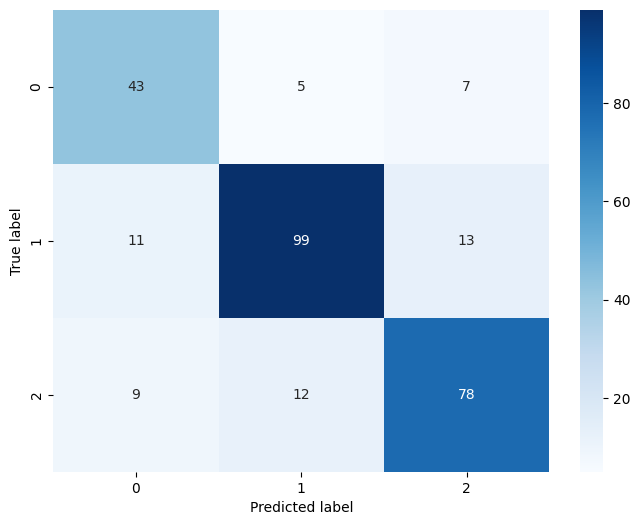

In [14]:

# Cell 12 — Confusion matrix & classification report
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

val_preds = trainer.predict(dataset["validation"])
preds = np.argmax(val_preds.predictions, axis=-1)
labels = val_preds.label_ids
print(classification_report(labels, preds, target_names=[id2label[i] for i in range(num_labels)]))

cm = confusion_matrix(labels, preds)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=[id2label[i] for i in range(num_labels)], yticklabels=[id2label[i] for i in range(num_labels)], cmap="Blues")
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.show()

In [15]:
from transformers import pipeline

# Updated pipeline (no deprecation warning)
inference_pipeline = pipeline(
    "text-classification",
    model="/content/hinglish_sentiment_final",
    tokenizer=tokenizer,
    top_k=1,  # replaces deprecated return_all_scores
    device=0 if __import__('torch').cuda.is_available() else -1
)

# Test examples
samples = [
    "ye movie bahut acchi thi, maza aa gaya",     # positive
    "service bilkul badiya nahi thi",             # negative
    "meh so-so tha, kuch khaas nahi"              # neutral
]

for text in samples:
    result = inference_pipeline(text)[0]   # pipeline returns list of dicts
    label_key = result["label"]

    # Handle possible formats: 'LABEL_0', 'label_1', '0', '1', or actual string label
    if isinstance(label_key, str) and any(x in label_key.upper() for x in ["LABEL", "label"]):
        label_num = int(''.join(filter(str.isdigit, label_key)))
        label_name = id2label.get(label_num, label_key)
    elif label_key.isdigit():
        label_name = id2label.get(int(label_key), label_key)
    else:
        label_name = label_key

    print(f"{text} → {label_name} ({result['score']:.3f})")

TypeError: list indices must be integers or slices, not str

In [16]:
# Normalize labels and verify mapping
label_map = {0: "negative", 1: "neutral", 2: "positive"}
df['label_text'] = df['label'].map(label_map)

print(df[['text', 'label', 'label_text']].head(10))
print("\nLabel distribution:")
print(df['label_text'].value_counts())

                                                text  label label_text
0  module , ek program hoti hai , jismen ya to so...      1    neutral
1  aur hamne aume samood ke pas unke bhaee saleh ...      2   positive
2  aur jab unhen yad dilaya jata hai , to ve yad ...      1    neutral
3            tumhen २०११ ka ted prize mil gaya hai\n      2   positive
4  unhonne bad science karne ke lie ye delhi univ...      1    neutral
5  phir hamne unhen bheja, taki maloom karen ki c...      2   positive
6  kya aap vakee raddi men sare photos and videos...      1    neutral
7  malabar men khudaee ke kamron men rakhe hue ba...      1    neutral
8  aur dharti ko ek samatal desolate maidan banak...      0   negative
9  mujhe dekhne ke lie jab aap ऑnlain ho dhanyvad!\n      2   positive

Label distribution:
label_text
neutral     1234
positive     987
negative     545
Name: count, dtype: int64


In [17]:
from transformers import pipeline

# create pipeline (no deprecated args)
inference_pipeline = pipeline(
    "text-classification",
    model="/content/hinglish_sentiment_final",
    tokenizer=tokenizer,
    top_k=1,  # ensures single best label
    device=0 if __import__('torch').cuda.is_available() else -1
)

samples = [
    "tumhen २०११ ka ted prize mil gaya hai",     # positive
    "service bilkul badiya nahi thi",             # negative
    "yadi aap yah mante hain ki aap kar sakte hain"              # neutral
]

for text in samples:
    # run model
    output = inference_pipeline(text)

    # handle different output shapes
    if isinstance(output, list):
        # if nested list (like [[{},{},{}]])
        if isinstance(output[0], list):
            result = output[0][0]
        else:
            result = output[0]
    else:
        result = output

    label_key = result.get("label", "")
    score = result.get("score", 0.0)

    # handle 'LABEL_0', 'label_1', or direct string labels
    if any(x in label_key.upper() for x in ["LABEL", "label"]):
        label_num = int(''.join(filter(str.isdigit, label_key)))
        label_name = id2label.get(label_num, label_key)
    elif label_key.isdigit():
        label_name = id2label.get(int(label_key), label_key)
    else:
        label_name = label_key

    print(f"{text} → {label_name} ({score:.3f})")

tumhen २०११ ka ted prize mil gaya hai → 2 (1.000)
service bilkul badiya nahi thi → 1 (1.000)
yadi aap yah mante hain ki aap kar sakte hain → 1 (1.000)
